# <font size="7"> **Assignment-7**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [1]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 7

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_full.numpy(), y_full.numpy(), test_size=0.3, random_state=GROUP_NUMBER
)
X_train, X_val = torch.FloatTensor(X_train), torch.FloatTensor(X_val)
y_train, y_val = torch.FloatTensor(y_train), torch.FloatTensor(y_val)

In [4]:
class MLPFromScratch:
    def __init__(self, input_size=2, hidden_size=16, output_size=1):
        self.w1 = torch.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.w1.requires_grad = True
        self.b1 = torch.zeros(1, hidden_size)
        self.b1.requires_grad = True

        self.w2 = torch.randn(hidden_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.w2.requires_grad = True
        self.b2 = torch.zeros(1, hidden_size)
        self.b2.requires_grad = True

        self.w3 = torch.randn(hidden_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.w3.requires_grad = True
        self.b3 = torch.zeros(1, hidden_size)
        self.b3.requires_grad = True

        self.w4 = torch.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.w4.requires_grad = True
        self.b4 = torch.zeros(1, output_size)
        self.b4.requires_grad = True

        self.params = [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3, self.w4, self.b4]

    def forward(self, X):
        a1 = torch.relu(torch.matmul(X, self.w1) + self.b1)
        a2 = torch.relu(torch.matmul(a1, self.w2) + self.b2)
        a3 = torch.relu(torch.matmul(a2, self.w3) + self.b3)
        return torch.sigmoid(torch.matmul(a3, self.w4) + self.b4)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

def binary_cross_entropy(y_pred, y_true, eps=1e-7):
    y_pred = torch.clamp(y_pred, eps, 1 - eps)
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))


In [5]:
def train_mlp(model, X_train, y_train, X_val, y_val, epochs=10000, lr=0.01):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.zero_grad()
        y_pred_train = model.forward(X_train)
        train_loss = binary_cross_entropy(y_pred_train, y_train)
        train_loss.backward()

        with torch.no_grad():
            for param in model.params:
                if param.grad is not None:
                    param.data -= lr * param.grad.data

        train_acc = ((y_pred_train > 0.5).float() == y_train).float().mean().item()

        with torch.no_grad():
            y_pred_val = model.forward(X_val)
            val_loss = binary_cross_entropy(y_pred_val, y_val)
            val_acc = ((y_pred_val > 0.5).float() == y_val).float().mean().item()

        history['train_loss'].append(train_loss.item())
        history['val_loss'].append(val_loss.item())
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss.item():.4f} | "
                  f"Val Loss: {val_loss.item():.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history

mlp = MLPFromScratch()
history = train_mlp(mlp, X_train, y_train, X_val, y_val, epochs=10000, lr=0.01)


Epoch 500/10000 | Train Loss: 0.6077 | Val Loss: 0.6308 | Train Acc: 0.6000 | Val Acc: 0.5567
Epoch 1000/10000 | Train Loss: 0.5975 | Val Loss: 0.6205 | Train Acc: 0.5848 | Val Acc: 0.5611
Epoch 1500/10000 | Train Loss: 0.5889 | Val Loss: 0.6109 | Train Acc: 0.5886 | Val Acc: 0.5700
Epoch 2000/10000 | Train Loss: 0.5805 | Val Loss: 0.6018 | Train Acc: 0.6043 | Val Acc: 0.5978
Epoch 2500/10000 | Train Loss: 0.5721 | Val Loss: 0.5922 | Train Acc: 0.6233 | Val Acc: 0.6278
Epoch 3000/10000 | Train Loss: 0.5623 | Val Loss: 0.5810 | Train Acc: 0.6467 | Val Acc: 0.6522
Epoch 3500/10000 | Train Loss: 0.5489 | Val Loss: 0.5663 | Train Acc: 0.6814 | Val Acc: 0.6756
Epoch 4000/10000 | Train Loss: 0.5266 | Val Loss: 0.5425 | Train Acc: 0.7152 | Val Acc: 0.7222
Epoch 4500/10000 | Train Loss: 0.4867 | Val Loss: 0.4991 | Train Acc: 0.7624 | Val Acc: 0.7689
Epoch 5000/10000 | Train Loss: 0.4593 | Val Loss: 0.4692 | Train Acc: 0.7862 | Val Acc: 0.7878
Epoch 5500/10000 | Train Loss: 0.4366 | Val Loss: 0

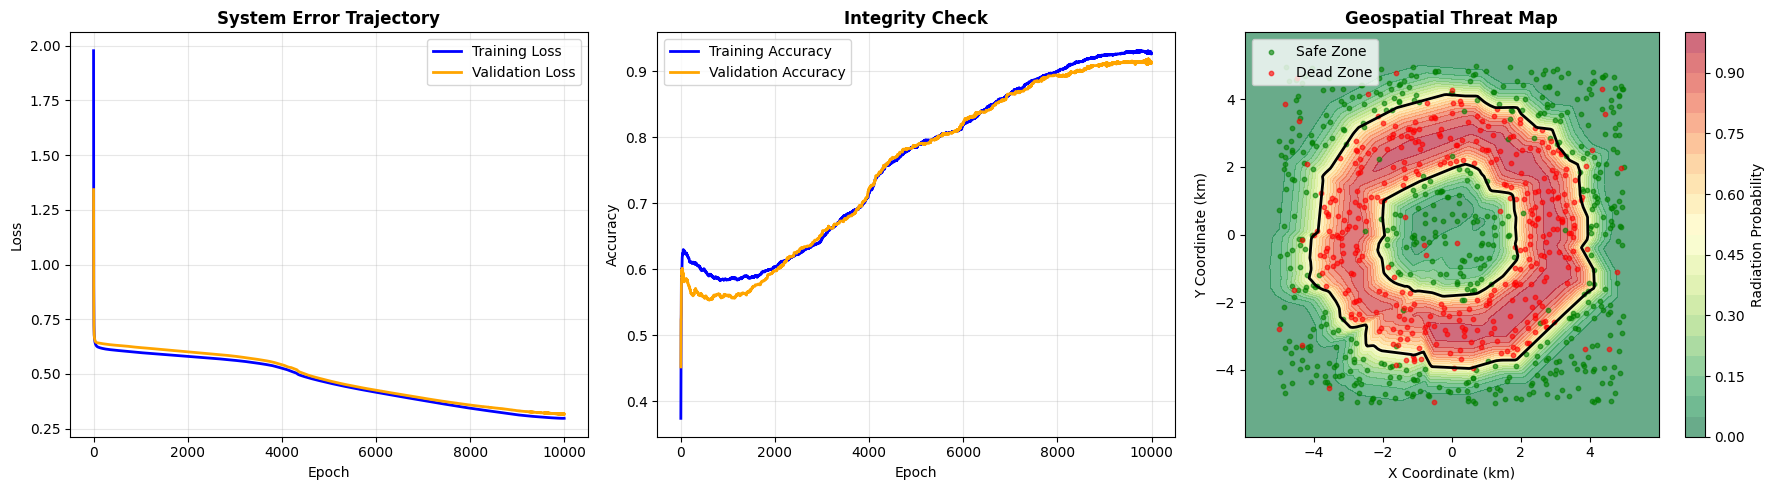


Final Training Accuracy: 0.9276
Final Validation Accuracy: 0.9133


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['train_loss'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('System Error Trajectory', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(history['val_acc'], label='Validation Accuracy', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Integrity Check', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

x_min, x_max = X_val[:, 0].min() - 1, X_val[:, 0].max() + 1
y_min, y_max = X_val[:, 1].min() - 1, X_val[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

with torch.no_grad():
    Z = mlp.forward(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy().reshape(xx.shape)

contour = axes[2].contourf(xx, yy, Z, levels=20, cmap='RdYlGn_r', alpha=0.6)
axes[2].contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

safe, danger = y_val.numpy().flatten() == 0, y_val.numpy().flatten() == 1
axes[2].scatter(X_val[safe, 0], X_val[safe, 1], c='green', label='Safe Zone', s=10, alpha=0.6)
axes[2].scatter(X_val[danger, 0], X_val[danger, 1], c='red', label='Dead Zone', s=10, alpha=0.6)
axes[2].set_xlabel('X Coordinate (km)')
axes[2].set_ylabel('Y Coordinate (km)')
axes[2].set_title('Geospatial Threat Map', fontweight='bold')
axes[2].legend()
plt.colorbar(contour, ax=axes[2], label='Radiation Probability')

plt.tight_layout()
plt.show()

print(f"\nFinal Training Accuracy: {history['train_acc'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")